# Creating the dataset for the training

---
**USEFUL LINKS :**

The paper and its github :

https://github.com/lindawangg/COVID-Net

---

In [1]:
# !pip install pydicom
!pip install "torch==1.4" "torchvision==0.5.0" # to avoid a warning spam

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 38.1MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [2]:
# IMPORTS :
from fastai.vision import *

import pandas as pd
import csv

from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AH68r_L45LD2uz4IoxN9ugO5LYbiQB9fLgaslVj1pdpF6AC3ESUwgQ
Mounted at /content/drive


In [4]:
# Unzip CovidX-v4 dataset

# unzip Dr Arganda-Carreras's file:
# !unzip -q '/content/drive/My Drive/Colab Notebooks/Internship/COVID19_DATA/Covid-X-v4.zip'

# unzip mine (a copy of Dr Arganda-Carreras's file)
!unzip -q '/content/drive/My Drive/Colab Notebooks/Internship/COVIDX_models/Covid-X-v4.zip'
print('Done!')

Done!


In [5]:
import pathlib
path = pathlib.Path( '/content/data' )
path.ls()

bs = 64

seed = 42
np.random.seed( seed )

train_path = pathlib.Path( '/content/data/train/' )
test_path = pathlib.Path( '/content/data/test/' )

train = pd.read_csv(path/"train_split.txt", sep=' ', header=None, names=['Image','Class','Origin']).drop('Origin',axis=1)
test = pd.read_csv(path/"test_split.txt", sep=' ', header=None, names=['Image','Class', 'Origin']).drop('Origin',axis=1)

# cv = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=seed)
# train_idx, val_idx = next(cv.split(train['Image'],train['Class']))

data = (ImageList.from_df(train, path = train_path)
                .split_none()
                # .split_by_idxs(train_idx.tolist(), val_idx.tolist())
                .label_from_df(cols=['Class'])
                .transform(tfms=get_transforms(max_warp=0.), size=224) 
                # .add_test(ImageList.from_df(test, path=test_path))
                .databunch(bs=bs, num_workers = 4)
                .normalize(imagenet_stats)
               )

data_test = (ImageList.from_df(test, path=test_path)
            .split_none()
            .label_from_df(cols=['Class'])
            .transform(tfms=get_transforms(max_warp=0.), size=224)
            )

data_test.valid = data_test.train
data_test = data_test.databunch(bs=bs, num_workers=4).normalize(imagenet_stats)

['COVID-19', 'normal', 'pneumonia']


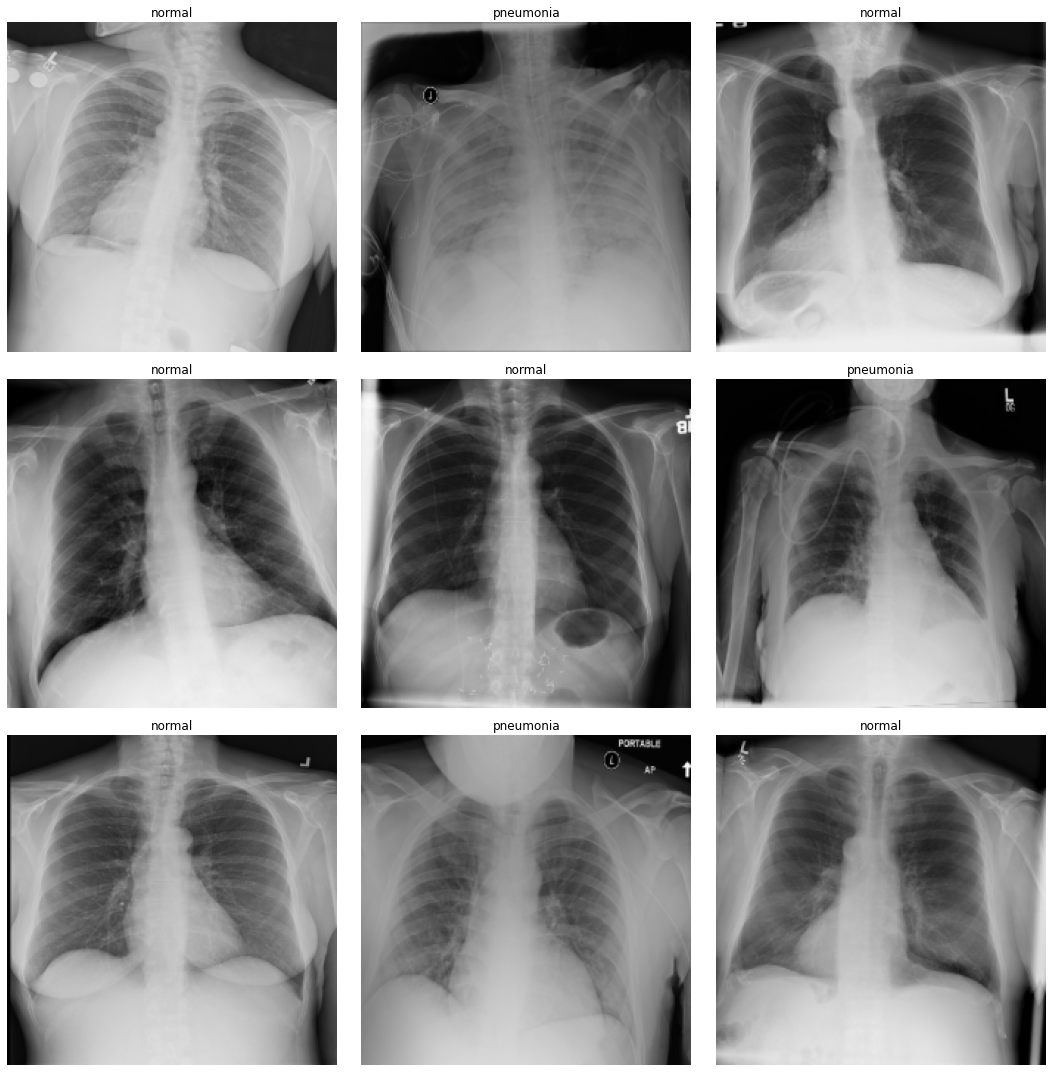

In [6]:
print(data.classes)

data.show_batch(rows=3, figsize=(15,15))

In [7]:
train

,Image,Class
3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia
...,...,...
c1628c47-5ba3-42dd-8df3-7ad3abd57ad0,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,pneumonia
c1cddf32-b957-4753-acaa-472ab1447e86,c1cddf32-b957-4753-acaa-472ab1447e86.png,pneumonia
c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,pneumonia
c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,pneumonia


# Creating the model

In [8]:
# !git clone https://github.com/sdoria/mish

In [9]:
# %cd mish
# from mish import *
# from mxresnet import *

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


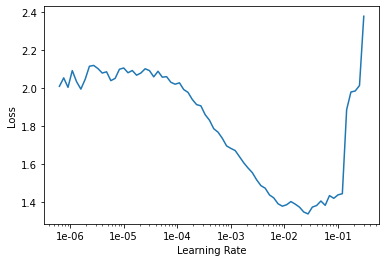

In [10]:
from fastai.callbacks import *

mod = models.densenet169
learn = cnn_learner(data, mod, metrics=[error_rate, accuracy, Precision(), Recall()]) #, callback_fns=[OverSamplingCallback])
weights = torch.tensor([50.,1.,2.]).cuda()
learn.loss_func = nn.CrossEntropyLoss(reduction= 'mean', weight=weights)

# name_save2 = '/content/drive/My Drive/Colab Notebooks/Internship/COVIDX_models/Fastai/densenet169_test_v6s1'

# #if loading an existing mdoel : 
# learn.load(name_save2)

# We use the test set as a validation set
learn.data.valid_dl = data_test.valid_dl

#If we want to know the learning rate :
learn.lr_find()
learn.recorder.plot()

First round of learning

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.658983,0.631313,0.221659,0.778341,0.689170,0.813683,10:02
1,0.499839,0.450404,0.117163,0.882837,0.800046,0.881735,10:02
2,0.433192,0.426847,0.139329,0.860671,0.764241,0.890180,10:15
3,0.337064,0.371403,0.124129,0.875871,0.857438,0.831203,10:28
4,0.227928,0.235414,0.081064,0.918936,0.900725,0.902646,10:23
5,0.196977,0.301369,0.113363,0.886637,0.810045,0.909493,10:33
6,0.162696,0.217712,0.079164,0.920836,0.866882,0.930201,10:45
7,0.138734,0.207919,0.075997,0.924003,0.892872,0.933561,10:44
8,0.112450,0.176871,0.062698,0.937302,0.919924,0.935003,10:21
9,0.110272,0.198903,0.072831,0.927169,0.912810,0.918073,10:34


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


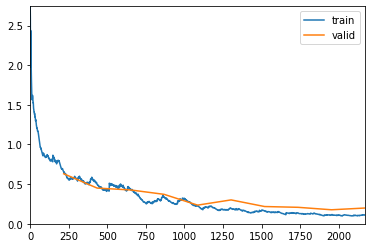

Better model found at epoch 0 with valid_loss value: 0.6313127279281616.
Better model found at epoch 1 with valid_loss value: 0.45040374994277954.
Better model found at epoch 2 with valid_loss value: 0.42684686183929443.
Better model found at epoch 3 with valid_loss value: 0.3714029788970947.
Better model found at epoch 4 with valid_loss value: 0.23541395366191864.
Better model found at epoch 6 with valid_loss value: 0.21771155297756195.
Better model found at epoch 7 with valid_loss value: 0.2079189270734787.
Better model found at epoch 8 with valid_loss value: 0.17687077820301056.


In [11]:
from fastai.callbacks import SaveModelCallback
lr = 1e-3 # using lr_find, we choose lr_max not too close from min

name_save = '/content/drive/My Drive/Colab Notebooks/Internship/COVIDX_models/Fastai/densenet169_test_v7s1'
# Set up the learning rate (controls the step size)
learn.fit_one_cycle(10, max_lr=lr, callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='valid_loss',name=name_save)])  # epoch = number of cycle during the training : forw & backw


In [12]:
# # Set up the learning rate (controls the step size)
# learn.fit_one_cycle(20, max_lr=lr/10, callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='valid_loss',name='/content/drive/My Drive/Colab Notebooks/Internship/COVIDX_models/Fastai/densenet169_test_v3s2')])  # epoch = number of cycle during the training : forw & backw


Second round of learning

In [13]:
# lr2 = 1e-4

# # Set up the learning rate (controls the step size)
# learn.fit_one_cycle(5, max_lr=lr2, callbacks=[ShowGraph(learn), SaveModelCallback(learn, every='improvement', monitor='accuracy',name='model')])  # epoch = number of cycle during the training : forw & backw
# learn.save('densenet169_v2s2' , return_path=True)

Let's see some of the most incorrect images, we also compute accuracy and error rate although the ones we will use are the ones computed with the test data.

Accuracy tensor(0.9367)
Error Rate tensor(0.0633)


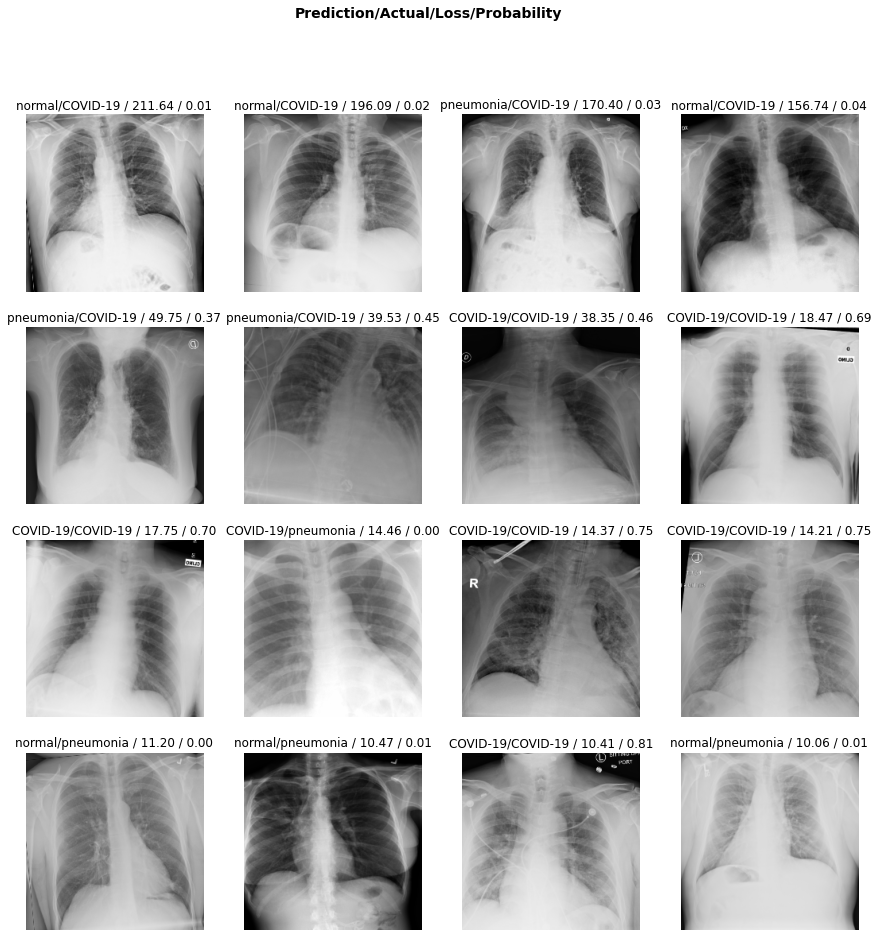

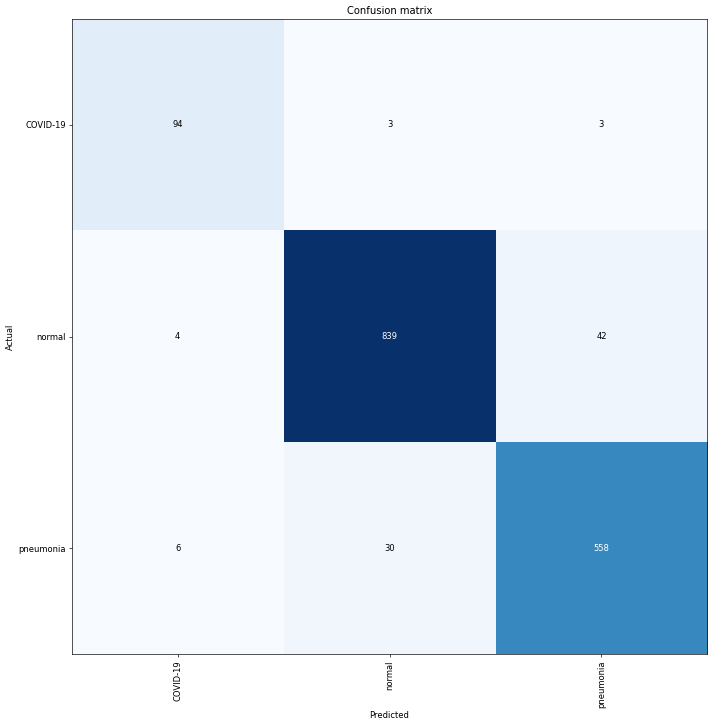

In [14]:
# What are the most incorrect ones?
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(16, figsize=(15,15)) # multi label version
# # Confusion matrix to compare the results :
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)  

probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid) 
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))

# Show + test

Old version (issues with the number of images in the end) (???)

In [15]:
# df_test = pd.read_csv(path/'test_split_v3.txt', sep = ' ', header = None, usecols = [1, 2])
# df_test.head()

#  data_test = (ImageDataBunch.from_df(path, df=df_test, folder='test',fn_col=0, label_col=1)
#         .split_none()    
#         .label_from_df()) 

# data_test.valid = data_test.train

# data_test = (data_test.transform(tfms = None, size=448)
        # .databunch(bs = 16))
        # .normalize(imagenet_stats))

New version adapted from COVIDX-Fastai-XResNet18.ipynb


In [16]:
data_test = (ImageList.from_df(test, path=test_path)
            .split_none()
            .label_from_df(cols=['Class'])
            .transform(tfms=None, size=224)
            )

data_test.valid = data_test.train
data_test = data_test.databunch(bs=bs, num_workers=4).normalize(imagenet_stats)

mod = models.densenet169
learn = cnn_learner(data_test, mod, metrics=[error_rate, accuracy, Precision(), Recall()]) 
learn.load(name_save)

Learner(data=ImageDataBunch;

Train: LabelList (1579 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/data/test;

Valid: LabelList (1579 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/data/test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, m

In [17]:
# # If need to load a different model :
# mod = models.densenet169
# learn = cnn_learner(data_test, mod, metrics=[accuracy])

# learn = learn.load(Path('Densenet169_v1s2'))

learn.data.valid_dl = data_test.valid_dl

# Interpret
interp = ClassificationInterpretation.from_learner(learn)


Let's see the most incorrect images

Accuracy tensor(0.9379)
Error Rate tensor(0.0621)


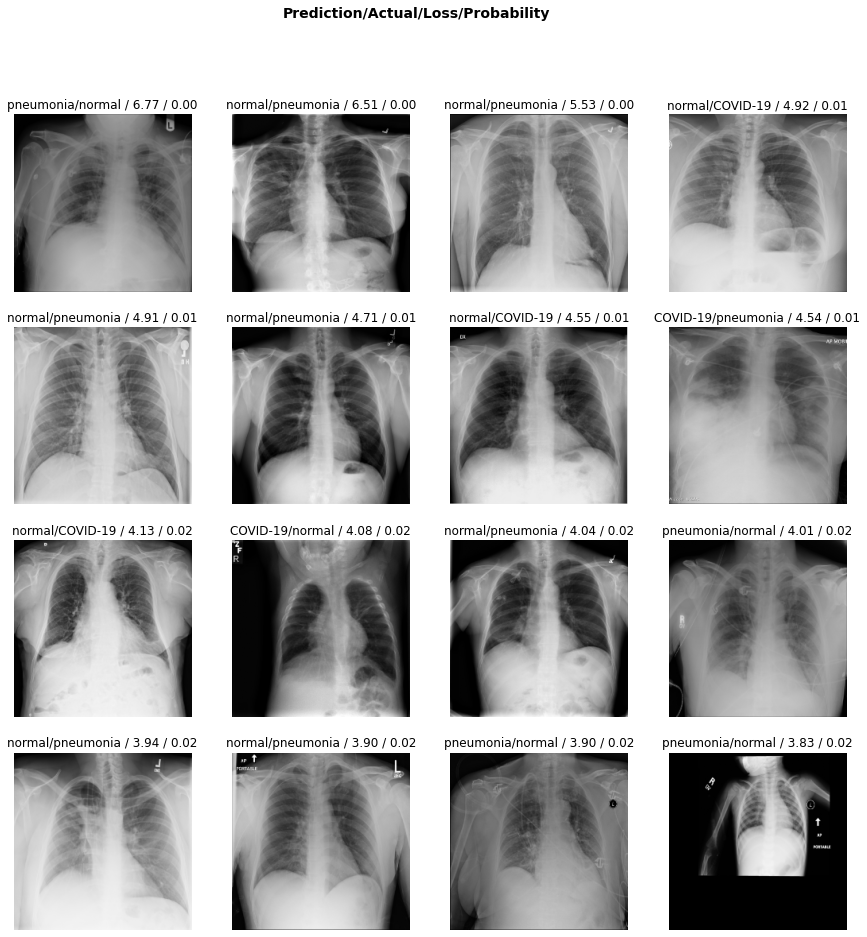

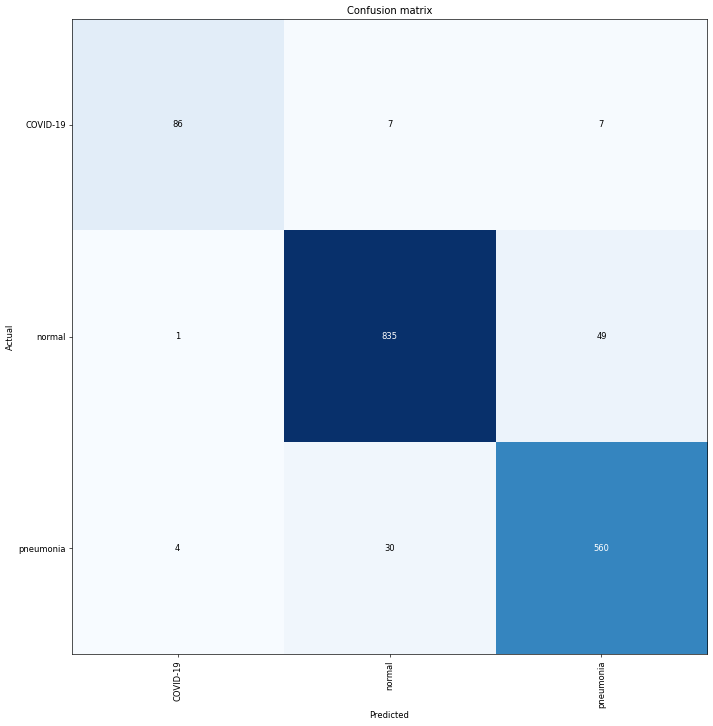

In [18]:
# What are the most incorrect ones?
interp.plot_top_losses(16, figsize=(15,15)) # multi label version
# # Confusion matrix to compare the results :
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)  

probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid)

print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))


Compute the recall and the Precision per class:

In [19]:
# adapted from COVIDX-Fastai-XResNet18.ipynb
# Convert dataframe test labels to list
gt = test['Class'].tolist()

# Convert from label names to class index values (0, 1, 2)
from sklearn import preprocessing
labels = data.classes
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
test_preds = le.transform( gt )

# I added this:
class_guess = probs.argmax(dim=1)

# Calculate accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score( class_guess.numpy(), np.asarray( test_preds ) )
print( "Accuracy = " + str( acc ) )

# Calculate precision per class
print(data.classes)

from sklearn.metrics import precision_score
prec = precision_score( class_guess.numpy(), np.asarray( test_preds ), average=None )
print( "Precision (Positive Predictive Value) per class = " + str( prec ))

# Calculate recall per class
from sklearn.metrics import recall_score
rec = recall_score(class_guess.numpy(), np.asarray(test_preds), average=None )
print( "Recall (Sensitiviy) per class = " + str( rec ))

Accuracy = 0.9379354021532615
['COVID-19', 'normal', 'pneumonia']
Precision (Positive Predictive Value) per class = [0.86     0.943503 0.942761]
Recall (Sensitiviy) per class = [0.945055 0.957569 0.909091]


In [20]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (1579 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/data/test;

Valid: LabelList (1579 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/data/test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1

# Recall, Accuracy, Precision, etc
https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

https://docs.fast.ai/metrics.html

Recall = sensitivity

Precision = Positive predictive value


